In [1]:
import pandas as pd
from IPython.display import display

# 读取 CSV 数据
df = pd.read_csv("consolidated_esg_single_row.csv")

# ---------------------
# 定义各维度的变量及其极性
# True 表示正向指标（值越高越好），False 表示负向指标（值越低越好）
env_vars = {
    'coal': False,
    'energy & consumption': False,
    'gas': False,
    'hydro': False,
    'oil': False,
    'scope1': False,
    'scope2': False,
    'scope3': False,
    'total & waste': False,
    'waste & recycled': False,
    'water & consumption': False,
    'wind': False
}

social_vars = {
    'fatal': False,  # 致命事件，越少越好
    'jobs': True,    # 就业机会，越多越好
    'management & women': True,  # 女性在管理层中的比例，假设越高越好
    'training & hours': True,    # 培训时长，越多越好
    'turnover': False            # 员工流失率，越低越好
}

governance_vars = {
    'G_value': True  # 假定治理得分，越高越好
}

# 如果希望利用性别数据计算员工性别比例，也可以添加：
if {"women", "male"}.issubset(df.columns):
    df["employee_gender_ratio"] = df["women"] / (df["women"] + df["male"])
    # 将计算出的比例作为社会维度的一个变量，假设比例越高越好
    social_vars["employee_gender_ratio"] = True

# ---------------------
# 定义一个函数来处理各组变量，计算百分位得分均值（转换到0-100分）
def process_vars(df, var_mapping):
    score_cols = []
    for col, higher_is_better in var_mapping.items():
        if col in df.columns:
            # 转换为数值型
            df[col] = pd.to_numeric(df[col], errors='coerce')
            df[col + "_score"] = df[col].rank(pct=True)
            # 若为负向指标，则反转百分位得分
            if not higher_is_better:
                df[col + "_score"] = 1 - df[col + "_score"]
            score_cols.append(col + "_score")
    if score_cols:
        return df[score_cols].mean(axis=1) * 100
    else:
        return None

# 计算各维度得分
df["E_score"] = process_vars(df, env_vars)
df["S_score"] = process_vars(df, social_vars)
df["G_score"] = process_vars(df, governance_vars)

# ---------------------
# 计算综合 ESG 得分，采用权重 E:40%, S:30%, G:30%
def compute_esg(row):
    available_scores = []
    weights = []
    if pd.notna(row["E_score"]):
        available_scores.append(row["E_score"])
        weights.append(0.4)
    if pd.notna(row["S_score"]):
        available_scores.append(row["S_score"])
        weights.append(0.3)
    if pd.notna(row["G_score"]):
        available_scores.append(row["G_score"])
        weights.append(0.3)
    if not available_scores:
        return None
    # 归一化权重
    norm_weights = [w / sum(weights) for w in weights]
    return sum(s * w for s, w in zip(available_scores, norm_weights))

df["ESG_score"] = df.apply(compute_esg, axis=1)

# 根据 ESG_score 转换为评级（阈值可根据数据分布调整）
def convert_grade(score):
    if pd.isna(score):
        return None
    if score < 30:
        return 'D'
    elif score < 40:
        return 'C-'
    elif score < 50:
        return 'C'
    elif score < 60:
        return 'C+'
    elif score < 67:
        return 'B-'
    elif score < 73:
        return 'B'
    elif score < 78:
        return 'B+'
    elif score < 83:
        return 'A-'
    elif score < 88:
        return 'A'
    else:
        return 'A+'


df["Grade"] = df["ESG_score"].apply(convert_grade)

# 显示最终结果
display(df[["Company", "E_score", "S_score", "G_score", "ESG_score", "Grade"]])
# 保存结果为 CSV 文件
df[["Company", "E_score", "S_score", "G_score", "ESG_score", "Grade"]].to_csv("esg_scored_result.csv", index=False)


,Company,E_score,S_score,G_score,ESG_score,Grade
0,Nofar,47.149123,51.052632,89.473684,61.017544,B-
1,LGES,50.877193,54.448622,39.473684,48.527569,C
2,Hitachi,46.491228,45.676692,89.473684,59.141604,C+
3,NFE,50.877193,50.526316,39.473684,47.350877,C
4,Gibson,37.500000,52.286967,100.000000,60.686090,B-
5,Constellation,56.578947,50.526316,39.473684,49.631579,C
6,ENN,32.236842,38.220551,89.473684,51.203008,C+
7,VITOL,57.236842,42.105263,39.473684,47.368421,C
8,NRG,60.745614,55.795739,39.473684,52.879073,C+
9,Capitalenergy,57.236842,55.795739,39.473684,51.475564,C+


In [2]:
# 计算 E, S, G 的 benchmark 指标
def benchmark_summary(score_col):
    if score_col in df.columns:
        return {
            "75%": df[score_col].quantile(0.75),
        }
    else:
        return None

# 分别生成 benchmark
E_benchmark = benchmark_summary("E_score")
S_benchmark = benchmark_summary("S_score")
G_benchmark = benchmark_summary("G_score")
ESG_benchmark = benchmark_summary("ESG_score")

# 显示
print("📘 E (Environment) Benchmark:")
print(E_benchmark)

print("\n📙 S (Social) Benchmark:")
print(S_benchmark)

print("\n📗 G (Governance) Benchmark:")
print(G_benchmark)

print("\n🌈 ESG Benchmark:")
print(ESG_benchmark)



📘 E (Environment) Benchmark:
{'75%': 57.236842105263165}

📙 S (Social) Benchmark:
{'75%': 55.12218045112782}

📗 G (Governance) Benchmark:
{'75%': 59.21052631578947}

🌈 ESG Benchmark:
{'75%': 53.01535087719298}


In [3]:
import numpy as np

greenwash_df = pd.read_csv("greenwashing_results.csv")
# 拆分 report 列为公司名和年份
greenwash_df[['Company_Short', 'Year']] = greenwash_df['report'].str.extract(r'(\w+)_([0-9]{4})')

# 计算 net_action_score 的均值和标准差
mean_score = greenwash_df["net_action_score"].mean()
std_score = greenwash_df["net_action_score"].std()

# 根据得分分布判断 controversy level
def classify_controversy(score):
    if score >= mean_score - std_score:
        return "None"
    elif score >= mean_score - 2 * std_score:
        return "Minor"
    elif score >= mean_score - 3 * std_score:
        return "Moderate"
    else:
        return "Severe"

greenwash_df["Controversy_Level"] = greenwash_df["net_action_score"].apply(classify_controversy)

# 添加 penalty
penalty_mapping = {
    "None": 0.00,
    "Minor": 0.05,
    "Moderate": 0.10,
    "Severe": 0.20
}
greenwash_df["Penalty"] = greenwash_df["Controversy_Level"].map(penalty_mapping)

# 显示结果前几行以确认处理成功
greenwash_df[["report", "Company_Short", "net_action_score", "Controversy_Level", "Penalty"]].head()


,report,Company_Short,net_action_score,Controversy_Level,Penalty
0,NFE_2022,NFE,0.353198,None,0.0
1,LGES_2023,LGES,0.496052,None,0.0
2,VITOL_2023,VITOL,0.390187,None,0.0
3,Nofar_2023,Nofar,0.319946,None,0.0
4,ENN_2023,ENN,0.500000,None,0.0


In [4]:
# 将 ESG 数据与 Greenwashing 惩罚数据按公司名合并
merged_df = df.merge(
    greenwash_df[["Company_Short", "Controversy_Level", "Penalty"]],
    left_on="Company",
    right_on="Company_Short",
    how="left"
)

# 缺失 Penalty 默认为 0（无争议）
merged_df["Penalty"] = merged_df["Penalty"].fillna(0)

# 计算 ESGC 分数
merged_df["ESGC_score"] = merged_df["ESG_score"] * (1 - merged_df["Penalty"])

# 计算 ESGC 等级
def convert_grade(score):
    if pd.isna(score):
        return None
    if score < 30:
        return 'D'
    elif score < 40:
        return 'C-'
    elif score < 50:
        return 'C'
    elif score < 60:
        return 'C+'
    elif score < 67:
        return 'B-'
    elif score < 73:
        return 'B'
    elif score < 78:
        return 'B+'
    elif score < 83:
        return 'A-'
    elif score < 88:
        return 'A'
    else:
        return 'A+'

merged_df["ESGC_Grade"] = merged_df["ESGC_score"].apply(convert_grade)

# 保存最终结果
output_path = "esgc_final_with_controversy.csv"
merged_df.to_csv(output_path, index=False)

# 显示最终几行作为检查
merged_df[["Company", "ESG_score", "Controversy_Level", "Penalty", "ESGC_score", "ESGC_Grade"]].head()


,Company,ESG_score,Controversy_Level,Penalty,ESGC_score,ESGC_Grade
0,Nofar,61.017544,None,0.0,61.017544,B-
1,LGES,48.527569,None,0.0,48.527569,C
2,Hitachi,59.141604,None,0.0,59.141604,C+
3,NFE,47.350877,None,0.0,47.350877,C
4,Gibson,60.686090,NaN,0.0,60.686090,B-


In [5]:
# 读取包含打分后的结果文件
scored_df = pd.read_csv("esg_scored_result.csv")

# 将 greenwashing 惩罚数据合并进打分后的数据
final_df = scored_df.merge(
    greenwash_df[["Company_Short", "Controversy_Level", "Penalty"]],
    left_on="Company",
    right_on="Company_Short",
    how="left"
)

# 缺失 penalty 默认为 0
final_df["Penalty"] = final_df["Penalty"].fillna(0)

# 计算 ESGC score
final_df["ESGC_score"] = final_df["ESG_score"] * (1 - final_df["Penalty"])

# 计算 ESGC 等级
final_df["ESGC_Grade"] = final_df["ESGC_score"].apply(convert_grade)

# 保存最终结果
final_output_path = "esgc_final_with_controversy.csv"
final_df.to_csv(final_output_path, index=False)

# 显示确认列
final_df[["Company", "ESG_score", "Controversy_Level", "Penalty", "ESGC_score", "ESGC_Grade"]].head()


,Company,ESG_score,Controversy_Level,Penalty,ESGC_score,ESGC_Grade
0,Nofar,61.017544,None,0.0,61.017544,B-
1,LGES,48.527569,None,0.0,48.527569,C
2,Hitachi,59.141604,None,0.0,59.141604,C+
3,NFE,47.350877,None,0.0,47.350877,C
4,Gibson,60.686090,NaN,0.0,60.686090,B-


In [6]:
# 使用 merged_df 而不是 df！
final_columns = [
    "Company", "ESG_score", "Controversy_Level", "Penalty", "ESGC_score", "ESGC_Grade",
    "E_score", "S_score", "G_score", "Grade",
    "coal", "energy & consumption", "gas", "hydro", "oil", "scope1", "scope2", "scope3",
    "total & waste", "waste & recycled", "water & consumption", "wind",
    "fatal", "jobs", "management & women", "training & hours", "turnover",
    "G_value",
    "employee_gender_ratio", "employee_gender_ratio_score", "greenwashing"  # 如果你添加过
]

# 检查哪些字段存在于 merged_df 中
existing_columns = [col for col in final_columns if col in merged_df.columns]
missing_columns = [col for col in final_columns if col not in merged_df.columns]
print(f"✅ 可导出字段数量：{len(existing_columns)}")
print(f"⚠️ 缺失字段：{missing_columns}")

# 导出现有字段
merged_df[existing_columns].to_csv("final_complete_esg.csv", index=False)
print("✅ 最终包含 ESG+Greenwashing 的完整文件已导出为 final_complete_esg.csv")


✅ 可导出字段数量：30
⚠️ 缺失字段：['greenwashing']
✅ 最终包含 ESG+Greenwashing 的完整文件已导出为 final_complete_esg.csv


In [7]:
display(final_df[["Company", "ESG_score", "Controversy_Level", "Penalty", "ESGC_score", "ESGC_Grade"]])

,Company,ESG_score,Controversy_Level,Penalty,ESGC_score,ESGC_Grade
0,Nofar,61.017544,None,0.00,61.017544,B-
1,LGES,48.527569,None,0.00,48.527569,C
2,Hitachi,59.141604,None,0.00,59.141604,C+
3,NFE,47.350877,None,0.00,47.350877,C
4,Gibson,60.686090,NaN,0.00,60.686090,B-
5,Constellation,49.631579,None,0.00,49.631579,C
6,ENN,51.203008,None,0.00,51.203008,C+
7,VITOL,47.368421,None,0.00,47.368421,C
8,NRG,52.879073,None,0.00,52.879073,C+
9,Capitalenergy,51.475564,None,0.00,51.475564,C+


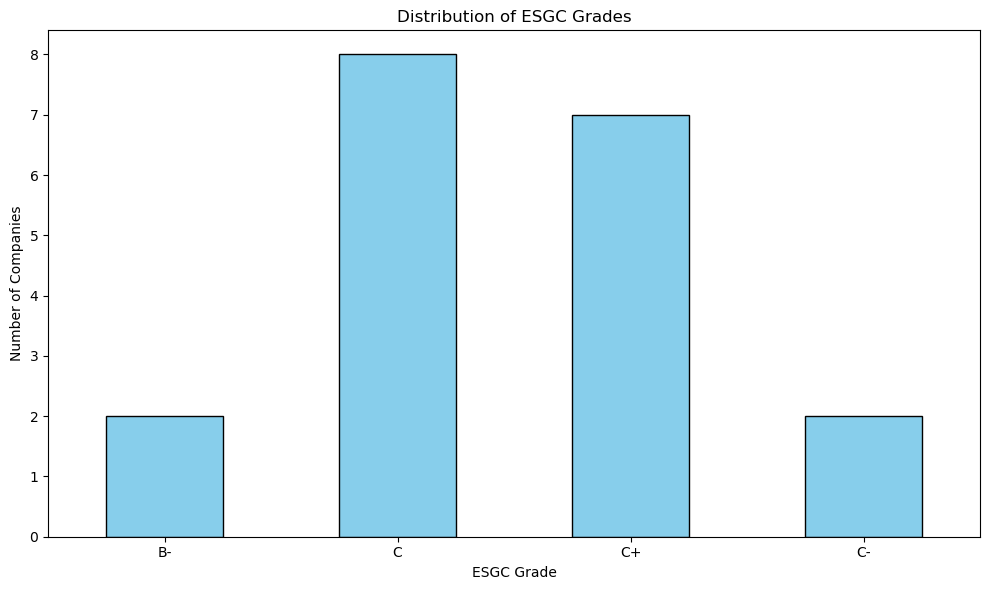

In [9]:
import pandas as pd
import matplotlib.pyplot as plt


# 统计 ESGC Grade 数量
grade_counts = final_df["ESGC_Grade"].value_counts().sort_index()

# 画图
plt.figure(figsize=(10, 6))
grade_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('ESGC Grade')
plt.ylabel('Number of Companies')
plt.title('Distribution of ESGC Grades')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


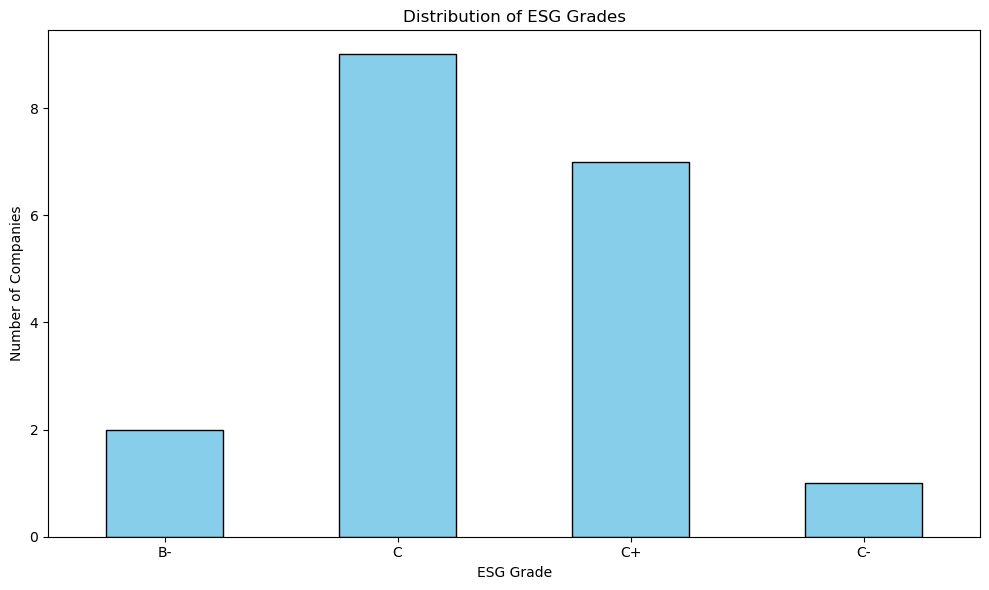

In [11]:
# 统计 ESGC Grade 数量
grade_counts = df["Grade"].value_counts().sort_index()

# 画图
plt.figure(figsize=(10, 6))
grade_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('ESG Grade')
plt.ylabel('Number of Companies')
plt.title('Distribution of ESG Grades')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()